## Foursquare credential

In [1]:
import os
import requests

# Foursquare credentials have been stored in local environment variables
CLIENT_ID = os.environ['FOURSQUARE_CLIENT_ID'] 
CLIENT_SECRET = os.environ['FOURSQUARE_CLIENT_SECRET'] 
VERSION = '20180605' # Foursquare API version

# Categories

In [2]:
url_categories = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION
        )

contents = requests.get(url_categories).json()
categories = contents['response']['categories']

### Categories at Top Layer

In [3]:
cat_lv0 = []
for i, child in enumerate(categories):
    print('{}. {}'.format(i, child['name']))
    cat_lv0.append(child['name'])

0. Arts & Entertainment
1. College & University
2. Event
3. Food
4. Nightlife Spot
5. Outdoors & Recreation
6. Professional & Other Places
7. Residence
8. Shop & Service
9. Travel & Transport


### Categories at Last Layer

In [4]:
def getLeafNodes(tr):
    if ((type(tr) is not dict) and (type(tr) is not list)):
        print('First parameter should be a List or a Dictionary!')
        return []
    
    if (type(tr) is dict):
        if (0 < len(tr['categories'])):
            return getLeafNodes(tr['categories'])
        else:
            return [tr['name']]
    else:
        result = []
        for i, child in enumerate(tr):
            result += getLeafNodes(child)
        return result

In [5]:
print('Number of categories at lowest level:', len(getLeafNodes(categories)))

Number of categories at lowest level: 896


### We could see that in Foursquare 's Category Database:
* At top level/level 0, there are 10 categories
* At lowest level (which have no child category), there are 896 categories<br>
To balance the level of details, in this project, I decided to use level 1 categories (level 1).

In [6]:
def getLv1Nodes(tr):
    result = []
    if ((type(tr) is not dict) and (type(tr) is not list)):
        print('First parameter should be a List or a Dictionary!')
        return result
    
    if (type(tr) is dict):
        if (0 < len(tr['categories'])):
            for child in tr['categories']:
                result.append(child['name'])
        else:
            result.append(tr['name'])
    else:
        for child in tr:
            if (0 < len(child['categories'])):
                for child in child['categories']:
                    result.append(child['name'])
            else:
                result.append(child['name'])            

    return result

In [7]:
cat_lv1 = getLv1Nodes(categories)
print('Number of categories at level 1:', len(cat_lv1))

Number of categories at level 1: 470


### Function to locate the position of a category in the database

In [8]:
def search(tr, item):
    """
    Locate position of a category in categories' database
    
    @return a tuple with two elements
                1st element is a sequence/list of nodes' indexes which lead to the position of the category
                2nd element is a sequence/list of comparison results of each node 's name with the category
                    if the category is in the database,
                        2nd element will contain a sub-element with value equals to 1
                        E.g.: [0, 0, ..., 1]
                    
    """
    if ((type(tr) is not dict) and (type(tr) is not list)):
        print('First parameter should be a List or a Dictionary!')
        return None
    
    if (type(tr) is dict):
        if ('name' in tr) and (item == tr['name']):
            return (['name'], [1])
        
        if ('categories' in tr) and (0 < len(tr['categories'])):
            result = search(tr['categories'], item)
            if (type(result) is tuple) and (type(result[1]) is list):
                return (['categories'] + result[0], [0] + result[1])

        return ([0], [0])
    else:
        for i, child in enumerate(tr):
            result = search(child, item)
            if (type(result) is tuple) and (type(result[1]) is list) and (1 in result[1]):
                return ([i] + result[0], [0] + result[1])
        return ([0], [0])

### Function to find the parent at level 1 of a category

In [9]:
def map_to_cat_lv1(cat):
    tree_path, results = search(categories, cat)
    if (1 in results):
        if (4 > len(tree_path)):
            print(cat, 'is a level 0 category!')
            return categories[tree_path[0]]['name']
        else:
            return categories[tree_path[0]][tree_path[1]][tree_path[2]]['name']
    else:
        return None

In [10]:
import pandas as pd
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my_explorer")

def getLocations(addrs):
    dct = {}
    dct['Area'] = []
    dct['Latitude'] = []
    dct['Longitude'] = []
    for addr in addrs:
        loc = geolocator.geocode(addr)
        if (loc is None):
            print(addr + ': no information!')
        else:
            dct['Area'].append(addr)
            dct['Latitude'].append(loc.latitude)
            dct['Longitude'].append(loc.longitude)
    df = pd.DataFrame(dct)
    return df

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
url_explore = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION
        )

In [91]:
minimum_number_of_venues = 10

# Function that query venues'information around input locations
def getNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        parameters = {
            'll':'{},{}'.format(lat, lng),
            'radius':2000,
            'limit':50
        }
            
        # make the GET request
        results = requests.get(url_explore, params=parameters).json()["response"]['groups'][0]['items']
        if (0 >= len(results)):
            print('No venue found around', name, '(', lat, ',', lng, ')!!!')
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    nearby_venues_counts = nearby_venues['Area'].value_counts()
    areas_to_drop = []
    for area in nearby_venues_counts.index:
        if nearby_venues_counts[area] < minimum_number_of_venues:
            areas_to_drop.append(area)

    nearby_venues = nearby_venues[~nearby_venues['Area'] .isin(areas_to_drop)]
    
    return(nearby_venues)

In [101]:
def preparation(df_venues):
    # map venue category to level 1-category
    # df_venues['Venue Category Level 1'] = df_venues['Venue Category'].apply(lambda cat: map_to_cat_lv1(cat))
    
    # one hot encoding
    df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

    # add postalcode column back to dataframe
    df_onehot['Area'] = df_venues['Area'] 

    # move Area column to the first column
    fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
    df_onehot = df_onehot[fixed_columns]

    df_grouped = df_onehot.groupby('Area').mean().reset_index()
    print('Grouped dimensions:', df_grouped.shape)
    return df_grouped

### Function to sort the venues in descending order

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
import numpy as np

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    if (len(indicators) > ind):
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    else:
        columns.append('{}th Most Common Venue'.format(ind+1))

def get_sorted_df(df_grouped):
    # create a new dataframe
    df_sorted = pd.DataFrame(columns=columns)
    df_sorted['Area'] = df_grouped['Area']

    for ind in np.arange(df_grouped.shape[0]):
        df_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

    return df_sorted

In [71]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

random_states = list(range(0, 10))

def inspect_k_means(df_grouped, kmin = 2, kmax = 8):
    df_grouped_clustering = df_grouped.drop('Area', 1)

    cluster_numbers = np.arange(kmin, kmax + 1)
    scores = np.zeros(kmax + 1)
    
    for n in cluster_numbers:
        for s in random_states:
            kmeans = KMeans(n_clusters=n, random_state=s).fit(df_grouped_clustering)
            scores[n] += silhouette_score(df_grouped_clustering, kmeans.labels_, metric='euclidean')
    
    scores = scores/len(random_states)
    
    fig, ax = plt.subplots()
    ax.plot(scores)
    ax.set_xlabel('Number of clusters')
    ax.set_xlim(cluster_numbers[0], cluster_numbers[-1])
    ax.set_ylabel('Silhouette Score')
    ax.set_title("Clustering Evaluation")

    plt.show()

In [97]:
def cluster(df_grouped, k=3):
    df_grouped_clustering = df_grouped.drop('Area', 1)
    best_random_state = 0
    best_silhouette_score = -1
    for s in random_states:
        kmeans = KMeans(n_clusters=k, random_state=s).fit(df_grouped_clustering)
        tmp = silhouette_score(df_grouped_clustering, kmeans.labels_, metric='euclidean')
        if (best_silhouette_score < tmp):
            best_silhouette_score = tmp
            best_random_state = s
    
    kmeans = KMeans(n_clusters=k, random_state=best_random_state).fit(df_grouped_clustering)
    print('Grouped data into', k, 'clusters -> Silhouette score:', silhouette_score(df_grouped_clustering, kmeans.labels_, metric='euclidean'))
    return kmeans.labels_

In [81]:
import folium
from geopy.geocoders import Nominatim
from matplotlib import cm, colors

geolocator = Nominatim(user_agent="my_explorer")

def visualize_clusters(central_address, df_clustered, labels):
    location = geolocator.geocode(central_address)
    latitude = location.latitude
    longitude = location.longitude

    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the clusters
    x = np.arange(len(labels))
    ys = [i + x + (i*x)**2 for i in range(len(labels))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    i = 0
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Area'], df_clustered['Cluster Labels']):
        label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
        map_clusters.add_child(
            folium.CircleMarker(
                [lat, lon],
                radius=5,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_color=rainbow[cluster-1],
                fill_opacity=0.7
            )
        )
        i += 1
    
    return map_clusters

## Beijing

In [18]:
url_beijing = 'https://en.wikipedia.org/wiki/List_of_administrative_divisions_of_Beijing'

import requests
wiki_beijing = requests.get(url_beijing)

from bs4 import BeautifulSoup
soup = BeautifulSoup(wiki_beijing.content, 'html.parser')

tables = soup.findAll('table')

In [19]:
import re

tab_districts = tables[3]
cells = tab_districts.findAll('td')
link_districts = cells[0].findAll('a')

districts = []
for ld in link_districts:
    if ('District' in ld['title']):
        tmp = re.sub(r'\s*District\s*', '', ld['title'])
        
    if ('Beijing' not in tmp):
        districts.append(tmp + ', Beijing')
    else:
        districts.append(tmp)

print(districts)

['Dongcheng, Beijing', 'Xicheng, Beijing', 'Shijingshan, Beijing', 'Chaoyang, Beijing', 'Haidian, Beijing', 'Fengtai, Beijing', 'Shijingshan, Beijing', 'Mentougou, Beijing', 'Fangshan, Beijing', 'Fangshan, Beijing', 'Shunyi, Beijing', 'Changping, Beijing', 'Daxing, Beijing', 'Pinggu, Beijing', 'Huairou, Beijing', 'Yanqing, Beijing', 'Miyun, Beijing']


In [20]:
df_beijing = getLocations(districts)
print(df_beijing.head())

                   Area   Latitude   Longitude
0    Dongcheng, Beijing  39.906217  116.391276
1      Xicheng, Beijing  39.910867  116.359922
2  Shijingshan, Beijing  39.904610  116.216797
3     Chaoyang, Beijing  39.920450  116.436911
4      Haidian, Beijing  39.958072  116.292405


In [102]:
beijing_venues = getNearbyVenues(
                names=df_beijing['Area'],
                latitudes=df_beijing['Latitude'],
                longitudes=df_beijing['Longitude']
              )

print('Number of venues:', len(beijing_venues))
beijing_venues.head()

No venue found around Fangshan, Beijing ( 39.7145318 , 115.86050079650428 )!!!
No venue found around Fangshan, Beijing ( 39.7145318 , 115.86050079650428 )!!!
Number of venues: 250


,Area,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dongcheng, Beijing",39.906217,116.391276,端门,39.908694,116.391192,Historic Site
1,"Dongcheng, Beijing",39.906217,116.391276,Gate of Supreme Harmony (太和门),39.913719,116.390880,Historic Site
2,"Dongcheng, Beijing",39.906217,116.391276,Zhongshan Park (Zhongshan Park 中山公园),39.908765,116.388602,Park
3,"Dongcheng, Beijing",39.906217,116.391276,Lost Heaven 花马天堂,39.900272,116.395612,Yunnan Restaurant
4,"Dongcheng, Beijing",39.906217,116.391276,中山音乐堂 Forbidden City Concert Hall,39.909374,116.389439,Concert Hall


Grouped dimensions: (7, 70)


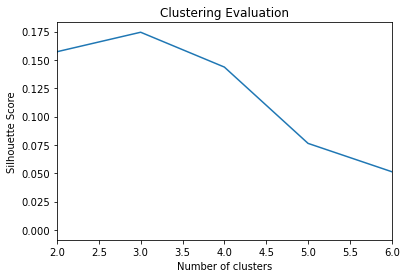

In [103]:
beijing_venues_grouped = preparation(beijing_venues)
beijing_venues_sorted = get_sorted_df(beijing_venues_grouped)
inspect_k_means(beijing_venues_grouped, kmax = beijing_venues_grouped.shape[0] - 1)

### From the graph, we could see that the best number of clusters is 3

In [104]:
beijing_venues_labels = cluster(beijing_venues_grouped, k = 3)
beijing_venues_sorted.insert(0, 'Cluster Labels', beijing_venues_labels)

beijing_venues_merged = df_beijing
beijing_venues_merged = beijing_venues_merged.join(beijing_venues_sorted.set_index('Area'), on='Area')
beijing_venues_merged.drop(beijing_venues_merged[beijing_venues_merged['Cluster Labels'].isnull()].index, inplace=True)
beijing_venues_merged['Cluster Labels'] = beijing_venues_merged['Cluster Labels'].astype('int32')
beijing_venues_merged.head() # check the last columns!

Grouped data into 3 clusters -> Silhouette score: 0.17441085273418297


,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Dongcheng, Beijing",39.906217,116.391276,2,Historic Site,Hotel,Coffee Shop,Park,Chinese Restaurant
1,"Xicheng, Beijing",39.910867,116.359922,0,Coffee Shop,Fast Food Restaurant,Hotel,Department Store,Shopping Mall
2,"Shijingshan, Beijing",39.904610,116.216797,0,Fast Food Restaurant,Hotel,Shopping Mall,Coffee Shop,Mongolian Restaurant
3,"Chaoyang, Beijing",39.920450,116.436911,2,Hotel,Cocktail Bar,Japanese Restaurant,Chinese Restaurant,Shopping Mall
4,"Haidian, Beijing",39.958072,116.292405,0,Fast Food Restaurant,Pizza Place,Hotel,Café,Coffee Shop


In [105]:
visualize_clusters('Beijing, China', beijing_venues_merged, beijing_venues_labels)

In [127]:
beijing_venues_merged

,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Dongcheng, Beijing",39.906217,116.391276,2,Historic Site,Hotel,Coffee Shop,Park,Chinese Restaurant
1,"Xicheng, Beijing",39.910867,116.359922,0,Coffee Shop,Fast Food Restaurant,Hotel,Department Store,Shopping Mall
2,"Shijingshan, Beijing",39.904610,116.216797,0,Fast Food Restaurant,Hotel,Shopping Mall,Coffee Shop,Mongolian Restaurant
3,"Chaoyang, Beijing",39.920450,116.436911,2,Hotel,Cocktail Bar,Japanese Restaurant,Chinese Restaurant,Shopping Mall
4,"Haidian, Beijing",39.958072,116.292405,0,Fast Food Restaurant,Pizza Place,Hotel,Café,Coffee Shop
6,"Shijingshan, Beijing",39.904610,116.216797,0,Fast Food Restaurant,Hotel,Shopping Mall,Coffee Shop,Mongolian Restaurant
11,"Changping, Beijing",40.219646,116.225091,1,Chinese Restaurant,Jewelry Store,Park,Gift Shop,Clothing Store
15,"Yanqing, Beijing",40.457305,115.978508,2,Hotel,Park,Campground,Chinese Restaurant,Korean Restaurant


## Shanghai

In [83]:
url_shanghai = 'https://en.wikipedia.org/wiki/List_of_administrative_divisions_of_Shanghai'

import requests
wiki_shanghai = requests.get(url_shanghai)

from bs4 import BeautifulSoup
sp_shanghai = BeautifulSoup(wiki_shanghai.content, 'html.parser')

tables_shanghai = sp_shanghai.findAll('table')

In [84]:
import re

districts_tab_shanghai = tables_shanghai[2]
cells_shanghai = districts_tab_shanghai.findAll('td')
link_districts_shanghai = cells_shanghai[0].findAll('a')

districts_shanghai = []
for ld in link_districts_shanghai:
    tmp = re.sub(r'\s*District\s*', '', ld['title'])

    if ('Shanghai' not in tmp):
        tmp += ', Shanghai'
    
    if (tmp not in districts_shanghai):
        districts_shanghai.append(tmp)

print(districts_shanghai)

['Huangpu, Shanghai', 'Xuhui, Shanghai', 'Changning, Shanghai', "Jing'an, Shanghai", 'Putuo, Shanghai', 'Hongkou, Shanghai', 'Yangpu, Shanghai', 'Pudong, Shanghai', 'Baoshan, Shanghai', 'Minhang, Shanghai', 'Jiading, Shanghai', 'Jinshan, Shanghai', 'Songjiang, Shanghai', 'Qingpu, Shanghai', 'Fengxian, Shanghai', 'Chongming, Shanghai']


In [85]:
df_shanghai = getLocations(districts_shanghai)
print(df_shanghai.head())

                  Area   Latitude   Longitude
0    Huangpu, Shanghai  31.232276  121.469207
1      Xuhui, Shanghai  31.163698  121.427994
2  Changning, Shanghai  31.209276  121.389986
3    Jing'an, Shanghai  31.229776  121.443060
4      Putuo, Shanghai  31.251326  121.391229


In [92]:
shanghai_venues = getNearbyVenues(
                names=df_shanghai['Area'],
                latitudes=df_shanghai['Latitude'],
                longitudes=df_shanghai['Longitude']
              )

print('Number of venues:', len(shanghai_venues))
shanghai_venues.head()

No venue found around Chongming, Shanghai ( 31.6313393 , 121.5337768 )!!!
Number of venues: 414


,Area,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Huangpu, Shanghai",31.232276,121.469207,Shanghai Grand Theater (上海大剧院),31.231030,121.467263,Theater
1,"Huangpu, Shanghai",31.232276,121.469207,Le Royal Club Lounge,31.236404,121.471364,Lounge
2,"Huangpu, Shanghai",31.232276,121.469207,Lobby Bar @ 38th floor - JW Marriott,31.232421,121.465553,Hotel Bar
3,"Huangpu, Shanghai",31.232276,121.469207,JW Marriott Hotel Shanghai at Tomorrow Square ...,31.232216,121.465260,Hotel
4,"Huangpu, Shanghai",31.232276,121.469207,Jing'an Sculpture Park (静安雕塑公园),31.234794,121.463911,Sculpture Garden


Grouped dimensions: (12, 106)


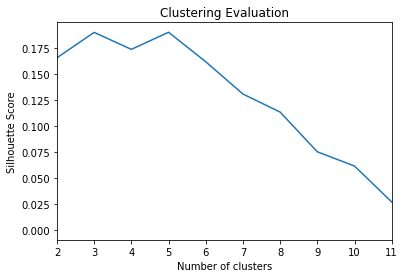

In [106]:
shanghai_venues_grouped = preparation(shanghai_venues)
shanghai_venues_sorted = get_sorted_df(shanghai_venues_grouped)
inspect_k_means(shanghai_venues_grouped, kmax = shanghai_venues_grouped.shape[0] - 1)

In [109]:
shanghai_venues_labels = cluster(shanghai_venues_grouped, k = 5)
shanghai_venues_sorted.insert(0, 'Cluster Labels', shanghai_venues_labels)

shanghai_venues_merged = df_shanghai

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
shanghai_venues_merged = shanghai_venues_merged.join(shanghai_venues_sorted.set_index('Area'), on='Area')
shanghai_venues_merged.drop(shanghai_venues_merged[shanghai_venues_merged['Cluster Labels'].isnull()].index, inplace=True)
shanghai_venues_merged['Cluster Labels'] = shanghai_venues_merged['Cluster Labels'].astype('int32')

shanghai_venues_merged.head() # check the last columns!

Grouped data into 5 clusters -> Silhouette score: 0.19045214996075088


,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Huangpu, Shanghai",31.232276,121.469207,4,Hotel,French Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant
1,"Xuhui, Shanghai",31.163698,121.427994,2,Fast Food Restaurant,Coffee Shop,Hotel,Chinese Restaurant,Shopping Mall
2,"Changning, Shanghai",31.209276,121.389986,0,Coffee Shop,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Korean Restaurant
3,"Jing'an, Shanghai",31.229776,121.443060,4,Hotel,Dumpling Restaurant,Hotpot Restaurant,Coffee Shop,Spa
4,"Putuo, Shanghai",31.251326,121.391229,2,Fast Food Restaurant,Hotel,Metro Station,Shopping Mall,Coffee Shop


In [110]:
visualize_clusters('Shanghai, China', shanghai_venues_merged, shanghai_venues_labels)

In [128]:
shanghai_venues_merged

,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Huangpu, Shanghai",31.232276,121.469207,4,Hotel,French Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant
1,"Xuhui, Shanghai",31.163698,121.427994,2,Fast Food Restaurant,Coffee Shop,Hotel,Chinese Restaurant,Shopping Mall
2,"Changning, Shanghai",31.209276,121.389986,0,Coffee Shop,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Korean Restaurant
3,"Jing'an, Shanghai",31.229776,121.443060,4,Hotel,Dumpling Restaurant,Hotpot Restaurant,Coffee Shop,Spa
4,"Putuo, Shanghai",31.251326,121.391229,2,Fast Food Restaurant,Hotel,Metro Station,Shopping Mall,Coffee Shop
5,"Hongkou, Shanghai",31.266703,121.501751,0,Coffee Shop,Fast Food Restaurant,Hotel,Park,Hotel Bar
6,"Yangpu, Shanghai",31.262011,121.521430,0,Coffee Shop,Hotel,Fast Food Restaurant,Chinese Restaurant,Plaza
7,"Pudong, Shanghai",31.221783,121.538740,0,Coffee Shop,Hotel,Italian Restaurant,Fast Food Restaurant,Pub
8,"Baoshan, Shanghai",31.406634,121.485158,3,Shopping Mall,Port,Boat or Ferry,Hotel,Fast Food Restaurant
9,"Minhang, Shanghai",31.114767,121.376943,0,Coffee Shop,Fast Food Restaurant,Shopping Mall,Zhejiang Restaurant,Burger Joint


## Singapore

In [111]:
url_singapore = 'https://www.mingproperty.sg/singapore-district-code/'
wiki_singapore = requests.get(url_singapore)
sp_singapore = BeautifulSoup(wiki_singapore.content, 'html.parser')

In [112]:
tables_singapore = sp_singapore.findAll('table')
rows = tables_singapore[1].findAll('tr')

districts_singapore = []

for row in rows[1:]:
    cells = row.findAll('td')
    tmp = cells[2].text.split(',')[0].strip()

    if ('Singapore' not in tmp):
        districts_singapore.append(tmp + ', Singapore')
    else:
        districts_singapore.append(tmp)

print(districts_singapore)

['Raffles Place, Singapore', 'Anson, Singapore', 'Queenstown, Singapore', 'Telok Blangah, Singapore', 'Pasir Panjang, Singapore', 'High Street, Singapore', 'Middle Road, Singapore', 'Little India, Singapore', 'Orchard, Singapore', 'Ardmore, Singapore', 'Watten Estate, Singapore', 'Balestier, Singapore', 'Macpherson, Singapore', 'Geylang, Singapore', 'Katong, Singapore', 'Bedok, Singapore', 'Loyang, Singapore', 'Tampines, Singapore', 'Serangoon Garden, Singapore', 'Bishan, Singapore', 'Upper Bukit Timah, Singapore', 'Jurong, Singapore', 'Hillview, Singapore', 'Lim Chu Kang, Singapore', 'Kranji, Singapore', 'Upper Thomson, Singapore', 'Yishun, Singapore', 'Seletar, Singapore']


In [113]:
df_singapore = getLocations(districts_singapore)
df_singapore.head()

,Area,Latitude,Longitude
0,"Raffles Place, Singapore",1.283542,103.851460
1,"Anson, Singapore",1.273796,103.843473
2,"Queenstown, Singapore",1.294623,103.806037
3,"Telok Blangah, Singapore",1.271020,103.809695
4,"Pasir Panjang, Singapore",1.276201,103.791476


In [115]:
singapore_venues = getNearbyVenues(
                names=df_singapore['Area'],
                latitudes=df_singapore['Latitude'],
                longitudes=df_singapore['Longitude']
              )

print('Number of venues:', len(singapore_venues))
singapore_venues.head()

Number of venues: 1300


,Area,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Raffles Place, Singapore",1.283542,103.85146,The Fullerton Bay Hotel,1.283878,103.853314,Hotel
1,"Raffles Place, Singapore",1.283542,103.85146,Ritual Gym,1.285965,103.848651,Gym
2,"Raffles Place, Singapore",1.283542,103.85146,The Fullerton Hotel,1.286200,103.852980,Hotel
3,"Raffles Place, Singapore",1.283542,103.85146,Amoy Hotel,1.283118,103.848539,Hotel
4,"Raffles Place, Singapore",1.283542,103.85146,Sabaai Sabaai Traditional Thai Massage,1.286964,103.849512,Massage Studio


Grouped dimensions: (28, 197)


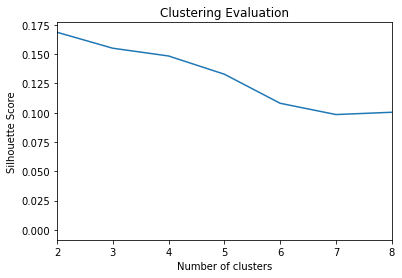

In [130]:
singapore_venues_grouped = preparation(singapore_venues)
singapore_venues_sorted = get_sorted_df(singapore_venues_grouped)
inspect_k_means(singapore_venues_grouped)

In [131]:
singapore_venues_labels = cluster(singapore_venues_grouped, k = 4)
singapore_venues_sorted.insert(0, 'Cluster Labels', singapore_venues_labels)

singapore_venues_merged = df_singapore
singapore_venues_merged = singapore_venues_merged.join(singapore_venues_sorted.set_index('Area'), on='Area')
singapore_venues_merged.drop(singapore_venues_merged[singapore_venues_merged['Cluster Labels'].isnull()].index, inplace=True)
singapore_venues_merged['Cluster Labels'] = singapore_venues_merged['Cluster Labels'].astype('int32')

singapore_venues_merged.head() # check the last columns!

Grouped data into 4 clusters -> Silhouette score: 0.17570940579475508


,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Raffles Place, Singapore",1.283542,103.851460,0,Hotel,Waterfront,Performing Arts Venue,Boutique,Wine Bar
1,"Anson, Singapore",1.273796,103.843473,0,Japanese Restaurant,Coffee Shop,Spanish Restaurant,Gym / Fitness Center,Wine Bar
2,"Queenstown, Singapore",1.294623,103.806037,2,Chinese Restaurant,Park,Café,Food Court,Asian Restaurant
3,"Telok Blangah, Singapore",1.271020,103.809695,2,Park,Trail,Scenic Lookout,Clothing Store,Shopping Mall
4,"Pasir Panjang, Singapore",1.276201,103.791476,2,Thai Restaurant,Coffee Shop,Chinese Restaurant,Seafood Restaurant,Cocktail Bar


In [132]:
visualize_clusters('Singapore', singapore_venues_merged, singapore_venues_labels)

In [133]:
singapore_venues_merged

,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Raffles Place, Singapore",1.283542,103.851460,0,Hotel,Waterfront,Performing Arts Venue,Boutique,Wine Bar
1,"Anson, Singapore",1.273796,103.843473,0,Japanese Restaurant,Coffee Shop,Spanish Restaurant,Gym / Fitness Center,Wine Bar
2,"Queenstown, Singapore",1.294623,103.806037,2,Chinese Restaurant,Park,Café,Food Court,Asian Restaurant
3,"Telok Blangah, Singapore",1.271020,103.809695,2,Park,Trail,Scenic Lookout,Clothing Store,Shopping Mall
4,"Pasir Panjang, Singapore",1.276201,103.791476,2,Thai Restaurant,Coffee Shop,Chinese Restaurant,Seafood Restaurant,Cocktail Bar
5,"High Street, Singapore",1.290383,103.849732,0,Hotel,Japanese Restaurant,Waterfront,Performing Arts Venue,Park
6,"Middle Road, Singapore",1.298630,103.853861,0,Hotel,Café,Japanese Restaurant,Park,Whisky Bar
7,"Little India, Singapore",1.306843,103.849274,0,Hotel,Indian Restaurant,Café,Clothing Store,Japanese Restaurant
8,"Orchard, Singapore",1.303427,103.831342,0,Hotel,Bakery,Clothing Store,Japanese Restaurant,Sushi Restaurant
9,"Ardmore, Singapore",1.308984,103.828897,0,Hotel,Bakery,Japanese Restaurant,Sushi Restaurant,Coffee Shop


## Hanoi

In [119]:
url_hanoi = 'https://en.wikipedia.org/wiki/Hanoi#List_of_local_government_divisions'
wiki_hanoi = requests.get(url_hanoi)
sp_hanoi = BeautifulSoup(wiki_hanoi.content, 'html.parser')

In [120]:
tables_hanoi = sp_hanoi.findAll('table')
districts_tab_hanoi = tables_hanoi[22]

cells_hanoi = districts_tab_hanoi.findAll('td')
link_districts_hanoi = cells_hanoi[0].findAll('a')

districts_hanoi = []

for ld in link_districts_hanoi:
    tmp = re.sub(r'\s*District\s*', '', ld['title'])

    if ('Hanoi' not in tmp):
        tmp += ', Hanoi'
    
    if (tmp not in districts_hanoi):
        districts_hanoi.append(tmp)

# Reduce the scope to 12 urban districts only
districts_hanoi = districts_hanoi[0:12]
print(districts_hanoi)

['Ba Đình, Hanoi', 'Bắc Từ Liêm, Hanoi', 'Cầu Giấy, Hanoi', 'Đống Đa, Hanoi', 'Hà Đông, Hanoi', 'Hai Bà Trưng, Hanoi', 'Hoàn Kiếm, Hanoi', 'Hoàng Mai, Hanoi', 'Long Biên, Hanoi', 'Nam Từ Liêm, Hanoi', 'Tây Hồ, Hanoi', 'Thanh Xuân, Hanoi']


In [121]:
df_hanoi = getLocations(districts_hanoi)
df_hanoi.head()

,Area,Latitude,Longitude
0,"Ba Đình, Hanoi",21.034075,105.814527
1,"Bắc Từ Liêm, Hanoi",21.069861,105.757339
2,"Cầu Giấy, Hanoi",21.029165,105.803438
3,"Đống Đa, Hanoi",21.012920,105.827196
4,"Hà Đông, Hanoi",20.970260,105.775001


In [122]:
hanoi_venues = getNearbyVenues(
                names=df_hanoi['Area'],
                latitudes=df_hanoi['Latitude'],
                longitudes=df_hanoi['Longitude']
              )

print('Number of venues:', len(hanoi_venues))
hanoi_venues.head()

Number of venues: 377


,Area,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Ba Đình, Hanoi",21.034075,105.814527,Sky Walk Lotte Centre,21.032131,105.812428,Scenic Lookout
1,"Ba Đình, Hanoi",21.034075,105.814527,Polygon Music,21.029922,105.822862,Rock Club
2,"Ba Đình, Hanoi",21.034075,105.814527,Cup of Tea Cafe & Bistro,21.033084,105.810379,Tea Room
3,"Ba Đình, Hanoi",21.034075,105.814527,Carambola Cafe,21.033445,105.816124,Café
4,"Ba Đình, Hanoi",21.034075,105.814527,Bornga - Original Korean Taste,21.031512,105.812575,Korean Restaurant


Grouped dimensions: (9, 94)


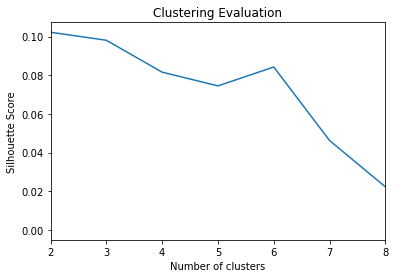

In [123]:
hanoi_venues_grouped = preparation(hanoi_venues)
hanoi_venues_sorted = get_sorted_df(hanoi_venues_grouped)
inspect_k_means(hanoi_venues_grouped)

In [124]:
hanoi_venues_labels = cluster(hanoi_venues_grouped, k = 6)
hanoi_venues_sorted.insert(0, 'Cluster Labels', hanoi_venues_labels)

hanoi_venues_merged = df_hanoi
hanoi_venues_merged = hanoi_venues_merged.join(hanoi_venues_sorted.set_index('Area'), on='Area')
hanoi_venues_merged.drop(hanoi_venues_merged[hanoi_venues_merged['Cluster Labels'].isnull()].index, inplace=True)
hanoi_venues_merged['Cluster Labels'] = hanoi_venues_merged['Cluster Labels'].astype('int32')

hanoi_venues_merged.head() # check the last columns!

Grouped data into 6 clusters -> Silhouette score: 0.08722318267859647


,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Ba Đình, Hanoi",21.034075,105.814527,2,Coffee Shop,Hotel,Vietnamese Restaurant,Café,Japanese Restaurant
2,"Cầu Giấy, Hanoi",21.029165,105.803438,2,Café,Japanese Restaurant,Vietnamese Restaurant,Coffee Shop,Korean Restaurant
3,"Đống Đa, Hanoi",21.012920,105.827196,4,Vietnamese Restaurant,Coffee Shop,Café,Hotel,BBQ Joint
5,"Hai Bà Trưng, Hanoi",21.005970,105.857484,3,Vietnamese Restaurant,Café,Japanese Restaurant,BBQ Joint,Coffee Shop
6,"Hoàn Kiếm, Hanoi",21.028524,105.850716,0,Hotel,Vietnamese Restaurant,Coffee Shop,Spa,Hostel


In [125]:
visualize_clusters('Hanoi, Vietnam', hanoi_venues_merged, hanoi_venues_labels)

In [134]:
hanoi_venues_merged

,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Ba Đình, Hanoi",21.034075,105.814527,2,Coffee Shop,Hotel,Vietnamese Restaurant,Café,Japanese Restaurant
2,"Cầu Giấy, Hanoi",21.029165,105.803438,2,Café,Japanese Restaurant,Vietnamese Restaurant,Coffee Shop,Korean Restaurant
3,"Đống Đa, Hanoi",21.012920,105.827196,4,Vietnamese Restaurant,Coffee Shop,Café,Hotel,BBQ Joint
5,"Hai Bà Trưng, Hanoi",21.005970,105.857484,3,Vietnamese Restaurant,Café,Japanese Restaurant,BBQ Joint,Coffee Shop
6,"Hoàn Kiếm, Hanoi",21.028524,105.850716,0,Hotel,Vietnamese Restaurant,Coffee Shop,Spa,Hostel
8,"Long Biên, Hanoi",21.039341,105.892245,5,Vietnamese Restaurant,Auto Garage,Shopping Mall,Bowling Alley,Market
9,"Nam Từ Liêm, Hanoi",21.012846,105.760874,1,Café,Coffee Shop,Bakery,Stadium,Tea Room
10,"Tây Hồ, Hanoi",21.079042,105.815432,4,Noodle House,Vietnamese Restaurant,Bakery,Pastry Shop,Café
11,"Thanh Xuân, Hanoi",20.993687,105.814301,4,Coffee Shop,Multiplex,Bakery,Pizza Place,Beer Bar
